In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import TargetEncoder

In [163]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [164]:
def read_data_and_choose(path_to_file: str, velocity: float, load: bool) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    if load:
        load_value = 80
    else:
        load_value = 0
    data = data[(data['angular_velocity'] == velocity) & (data['load_value'] == load_value)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [165]:
def do_rfft_features(data: pd.DataFrame) -> pd.DataFrame:
    y = data['defect']
    X = data.drop(columns=['defect']).values
    X_transformed = np.array(np.abs(rfft(X[0, :])))
    for i in range(1, X.shape[0]):
        X_transformed = np.vstack((X_transformed, np.abs(rfft(X[i, :]))))
    data = pd.DataFrame(X_transformed, y).reset_index().rename(columns={'index': 'defect'})
    return data

In [166]:
def get_features_and_target(velocity: float, load: bool, n_cols: int) -> pd.DataFrame:
    data_eccentricity = read_data_and_choose('eccentricity.csv', velocity, load)
    data_missing_tooth = read_data_and_choose('missing_tooth.csv', velocity, load)
    data_no_fault = read_data_and_choose('no_fault.csv', velocity, load)
    data_root_crack = read_data_and_choose('root_crack.csv', velocity, load)
    data_surface_fault = read_data_and_choose('surface_fault.csv', velocity, load)
    data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv', velocity, load)
    
    n_rows = 25000 // n_cols
    remain = 25000 % n_cols
    if remain == 0:
        
        X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data
    
    else:
        
        X_1 = data_eccentricity['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_1 = np.array(['eccentricity' for _ in range(n_rows)])

        X_2 = data_missing_tooth['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

        X_3 = data_no_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_3 = np.array(['no_fault' for _ in range(n_rows)])

        X_4 = data_root_crack['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_4 = np.array(['root_crack' for _ in range(n_rows)])

        X_5 = data_surface_fault['displacements'].values[: -(25000 % n_cols)].reshape(n_rows, n_cols)
        y_5 = np.array(['surface_fault' for _ in range(n_rows)])

        X_6 = data_tooth_chipped_fault['displacements'][: -(25000 % n_cols)].values.reshape(n_rows, n_cols)
        y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

        X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
        y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
        data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})
        return data

In [167]:
def get_all_features_and_targets(n_cols: int, do_fft: bool) -> pd.DataFrame:
    data_1 = get_features_and_target(velocity=8.33203125, load=False, n_cols=n_cols)
    if do_fft:
        data_1 = do_rfft_features(data_1)
    data_1['velocity'] = 8.33203125
    data_1['load'] = 0.0
    data_2 = get_features_and_target(velocity=8.33203125, load=True, n_cols=n_cols)
    if do_fft:
        data_2 = do_rfft_features(data_2)
    data_2['velocity'] = 8.33203125
    data_2['load'] = 80.0
    data_3 = get_features_and_target(velocity=25.0, load=False, n_cols=n_cols)
    if do_fft:
        data_3 = do_rfft_features(data_3)
    data_3['velocity'] = 25.0
    data_3['load'] = 0.0
    data_4 = get_features_and_target(velocity=25.0, load=True, n_cols=n_cols)
    if do_fft:
        data_4 = do_rfft_features(data_4)
    data_4['velocity'] = 25.0
    data_4['load'] = 80.0
    data_5 = get_features_and_target(velocity=40.0, load=False, n_cols=n_cols)
    if do_fft:
        data_5 = do_rfft_features(data_5)
    data_5['velocity'] = 40.0
    data_5['load'] = 0.0
    data_6 = get_features_and_target(velocity=40.0, load=True, n_cols=n_cols)
    if do_fft:
        data_6 = do_rfft_features(data_6)
    data_6['velocity'] = 40.0
    data_6['load'] = 80.0
    data = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6], axis=0)
    data = data.reset_index().drop(columns='index', axis=1)
    data = data.rename(str, axis="columns") 
    return data

In [168]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [169]:
#df = pd.get_dummies(df, columns=['velocity', 'load'], drop_first=True, dtype=float)
#df

In [170]:
X = df.drop(columns='defect')
y = df['defect']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [172]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

0.17307692307692307

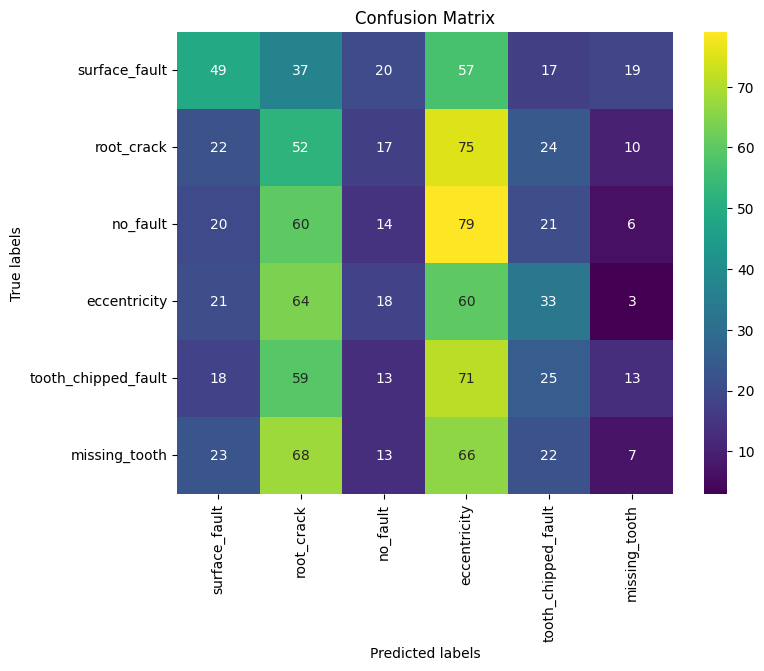

In [173]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [174]:
labels

array(['surface_fault', 'root_crack', 'no_fault', 'eccentricity',
       'tooth_chipped_fault', 'missing_tooth'], dtype=object)

Дерево решений

In [121]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 1000),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-19 00:17:06,454] A new study created in memory with name: Tree
[I 2024-05-19 00:17:08,370] Trial 0 finished with value: 0.37552301255230125 and parameters: {'max_depth': 988}. Best is trial 0 with value: 0.37552301255230125.
[I 2024-05-19 00:17:10,343] Trial 1 finished with value: 0.39539748953974896 and parameters: {'max_depth': 522}. Best is trial 1 with value: 0.39539748953974896.
[I 2024-05-19 00:17:12,420] Trial 2 finished with value: 0.3786610878661088 and parameters: {'max_depth': 602}. Best is trial 1 with value: 0.39539748953974896.
[I 2024-05-19 00:17:14,563] Trial 3 finished with value: 0.399581589958159 and parameters: {'max_depth': 329}. Best is trial 3 with value: 0.399581589958159.
[I 2024-05-19 00:17:16,776] Trial 4 finished with value: 0.3817991631799163 and parameters: {'max_depth': 813}. Best is trial 3 with value: 0.399581589958159.
[I 2024-05-19 00:17:19,008] Trial 5 finished with value: 0.3723849372384937 and parameters: {'max_depth': 132}. Best is tria

In [122]:
study.best_params

{'max_depth': 148}

In [157]:
best_params = {'max_depth': 148}

In [158]:
d_tree = DecisionTreeClassifier(**best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.8252508361204013

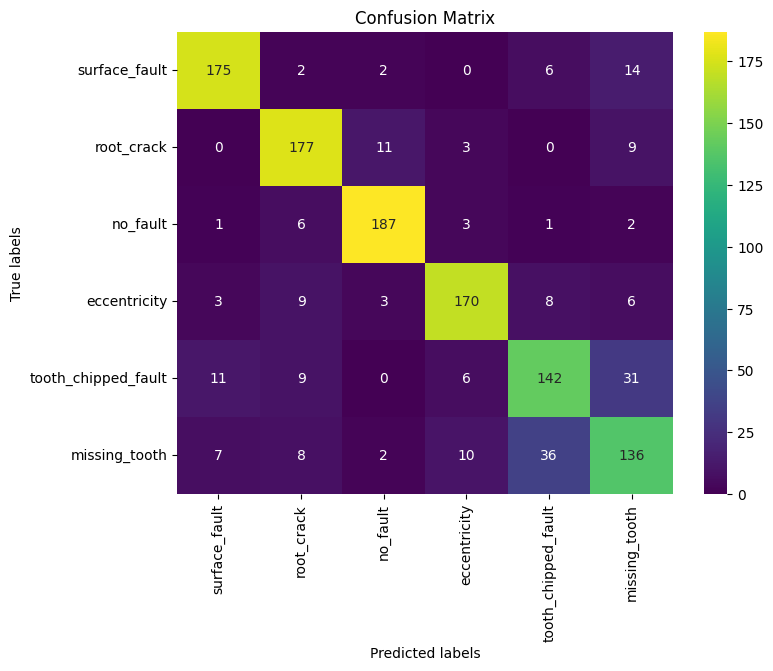

In [159]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Градиентный бустинг

In [129]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [130]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, timeout=100)

[I 2024-05-19 00:20:16,123] A new study created in memory with name: Boosting
[I 2024-05-19 00:20:16,807] Trial 0 finished with value: 0.48535564853556484 and parameters: {'learning_rate': 1.1982242990043197, 'num_leaves': 1163, 'reg_lambda': 0.8312865912118991, 'reg_alpha': 0.42895603459184095, 'min_child_samples': 17}. Best is trial 0 with value: 0.48535564853556484.
[I 2024-05-19 00:20:17,874] Trial 1 finished with value: 0.6799163179916318 and parameters: {'learning_rate': 0.44087304754772244, 'num_leaves': 673, 'reg_lambda': 0.1246601124983453, 'reg_alpha': 0.04055014919269784, 'min_child_samples': 94}. Best is trial 1 with value: 0.6799163179916318.
[I 2024-05-19 00:20:20,751] Trial 2 finished with value: 0.6485355648535565 and parameters: {'learning_rate': 0.09049298152788922, 'num_leaves': 1393, 'reg_lambda': 0.34985742937176245, 'reg_alpha': 0.7571789346880907, 'min_child_samples': 26}. Best is trial 1 with value: 0.6799163179916318.
[I 2024-05-19 00:20:22,054] Trial 3 finishe

[I 2024-05-19 00:21:27,578] Trial 28 finished with value: 0.6799163179916318 and parameters: {'learning_rate': 0.19600030243043579, 'num_leaves': 336, 'reg_lambda': 0.33116757281058723, 'reg_alpha': 0.17359146300320857, 'min_child_samples': 85}. Best is trial 17 with value: 0.6903765690376569.
[I 2024-05-19 00:21:28,804] Trial 29 finished with value: 0.645397489539749 and parameters: {'learning_rate': 0.546857141891799, 'num_leaves': 912, 'reg_lambda': 0.4277464527023491, 'reg_alpha': 0.370143006511223, 'min_child_samples': 92}. Best is trial 17 with value: 0.6903765690376569.
[I 2024-05-19 00:21:29,873] Trial 30 finished with value: 0.5753138075313807 and parameters: {'learning_rate': 0.8430315921516641, 'num_leaves': 1078, 'reg_lambda': 0.3136745979253809, 'reg_alpha': 0.24237323839136174, 'min_child_samples': 48}. Best is trial 17 with value: 0.6903765690376569.
[I 2024-05-19 00:21:35,846] Trial 31 finished with value: 0.6757322175732218 and parameters: {'learning_rate': 0.170543392

In [131]:
study.best_params

{'learning_rate': 0.1310051399637737,
 'num_leaves': 3725,
 'reg_lambda': 0.3761956763599664,
 'reg_alpha': 0.06294868630047017,
 'min_child_samples': 37}

In [132]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.6613712374581939

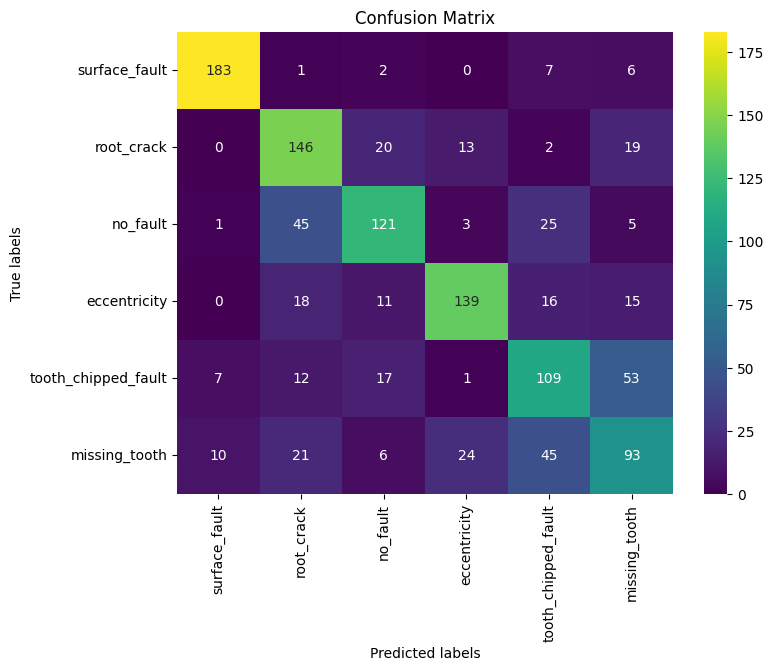

In [133]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Градиентный бустинг дал лучший результат

**Преобразование Фурье**

In [135]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [136]:
X = df.drop(columns='defect')
y = df['defect']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [138]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.46070234113712377

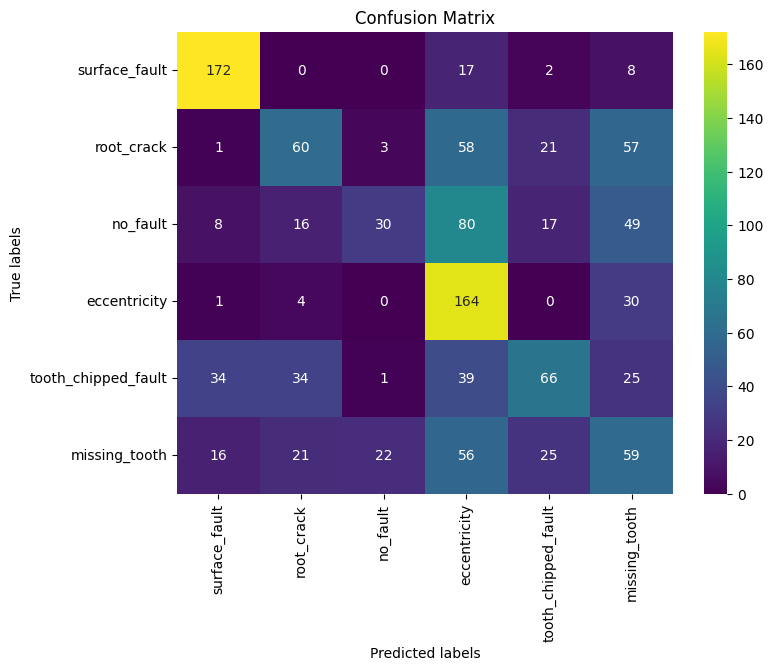

In [139]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Дерево решений

In [140]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 1000),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-19 00:25:51,670] A new study created in memory with name: Tree
[I 2024-05-19 00:25:52,324] Trial 0 finished with value: 0.8493723849372385 and parameters: {'max_depth': 560}. Best is trial 0 with value: 0.8493723849372385.
[I 2024-05-19 00:25:53,000] Trial 1 finished with value: 0.852510460251046 and parameters: {'max_depth': 356}. Best is trial 1 with value: 0.852510460251046.
[I 2024-05-19 00:25:53,685] Trial 2 finished with value: 0.8483263598326359 and parameters: {'max_depth': 26}. Best is trial 1 with value: 0.852510460251046.
[I 2024-05-19 00:25:54,374] Trial 3 finished with value: 0.854602510460251 and parameters: {'max_depth': 885}. Best is trial 3 with value: 0.854602510460251.
[I 2024-05-19 00:25:55,087] Trial 4 finished with value: 0.8514644351464435 and parameters: {'max_depth': 237}. Best is trial 3 with value: 0.854602510460251.
[I 2024-05-19 00:25:55,793] Trial 5 finished with value: 0.850418410041841 and parameters: {'max_depth': 87}. Best is trial 3 with va

In [141]:
study.best_params

{'max_depth': 993}

In [160]:
best_params = {'max_depth': 993}

In [142]:
d_tree = DecisionTreeClassifier(**best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.8085284280936454

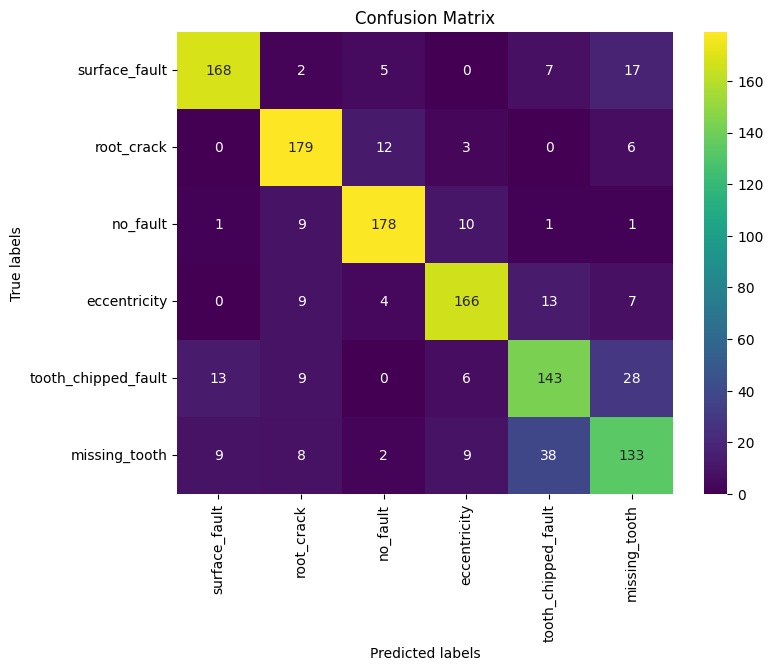

In [143]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Градиентный бустинг

In [144]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'multiclass',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    
    return accuracy
    

In [145]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, timeout=100)

[I 2024-05-19 00:26:40,669] A new study created in memory with name: Boosting
[I 2024-05-19 00:26:40,846] Trial 0 finished with value: 0.9236401673640168 and parameters: {'learning_rate': 0.876483123784461, 'num_leaves': 810, 'reg_lambda': 0.6327877921196284, 'reg_alpha': 0.3913698232418029, 'min_child_samples': 82}. Best is trial 0 with value: 0.9236401673640168.
[I 2024-05-19 00:26:41,014] Trial 1 finished with value: 0.9006276150627615 and parameters: {'learning_rate': 1.2304180955032982, 'num_leaves': 1209, 'reg_lambda': 0.5939426437927656, 'reg_alpha': 0.7906605370507024, 'min_child_samples': 94}. Best is trial 0 with value: 0.9236401673640168.
[I 2024-05-19 00:26:41,225] Trial 2 finished with value: 0.9037656903765691 and parameters: {'learning_rate': 1.2157815535558991, 'num_leaves': 1561, 'reg_lambda': 0.5106640468326592, 'reg_alpha': 0.2729403350064854, 'min_child_samples': 37}. Best is trial 0 with value: 0.9236401673640168.
[I 2024-05-19 00:26:41,757] Trial 3 finished with v

[I 2024-05-19 00:27:06,738] Trial 28 finished with value: 0.9476987447698745 and parameters: {'learning_rate': 0.6243004216458778, 'num_leaves': 2851, 'reg_lambda': 0.0978463984004534, 'reg_alpha': 0.07345512907444546, 'min_child_samples': 80}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:07,518] Trial 29 finished with value: 0.9372384937238494 and parameters: {'learning_rate': 0.7584175414066892, 'num_leaves': 3622, 'reg_lambda': 0.2572331726447931, 'reg_alpha': 0.3990766400420387, 'min_child_samples': 90}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:08,920] Trial 30 finished with value: 0.9623430962343096 and parameters: {'learning_rate': 0.1829329823074629, 'num_leaves': 2975, 'reg_lambda': 0.18487363446374072, 'reg_alpha': 0.07100388124502806, 'min_child_samples': 81}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:10,507] Trial 31 finished with value: 0.9623430962343096 and parameters: {'learning_rate': 0.14847

[I 2024-05-19 00:27:45,112] Trial 56 finished with value: 0.9612970711297071 and parameters: {'learning_rate': 0.18169407559636985, 'num_leaves': 3481, 'reg_lambda': 0.034967736396362664, 'reg_alpha': 0.18592543737662753, 'min_child_samples': 97}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:48,955] Trial 57 finished with value: 0.9320083682008368 and parameters: {'learning_rate': 0.05554053502473415, 'num_leaves': 2393, 'reg_lambda': 0.2285924152389126, 'reg_alpha': 0.083144458548338, 'min_child_samples': 4}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:50,080] Trial 58 finished with value: 0.9560669456066946 and parameters: {'learning_rate': 0.27280103556048696, 'num_leaves': 3215, 'reg_lambda': 0.07108977137858179, 'reg_alpha': 0.13173378234968627, 'min_child_samples': 83}. Best is trial 23 with value: 0.9665271966527197.
[I 2024-05-19 00:27:50,762] Trial 59 finished with value: 0.9320083682008368 and parameters: {'learning_rate': 1.04

In [146]:
study.best_params

{'learning_rate': 0.2403462227354661,
 'num_leaves': 3463,
 'reg_lambda': 0.003914470135492306,
 'reg_alpha': 0.0961882352006507,
 'min_child_samples': 99}

In [161]:
best_params = {'learning_rate': 0.2403462227354661,
 'num_leaves': 3463,
 'reg_lambda': 0.003914470135492306,
 'reg_alpha': 0.0961882352006507,
 'min_child_samples': 99}

In [147]:
boosting_clf = LGBMClassifier(verbose=-1, **best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9464882943143813

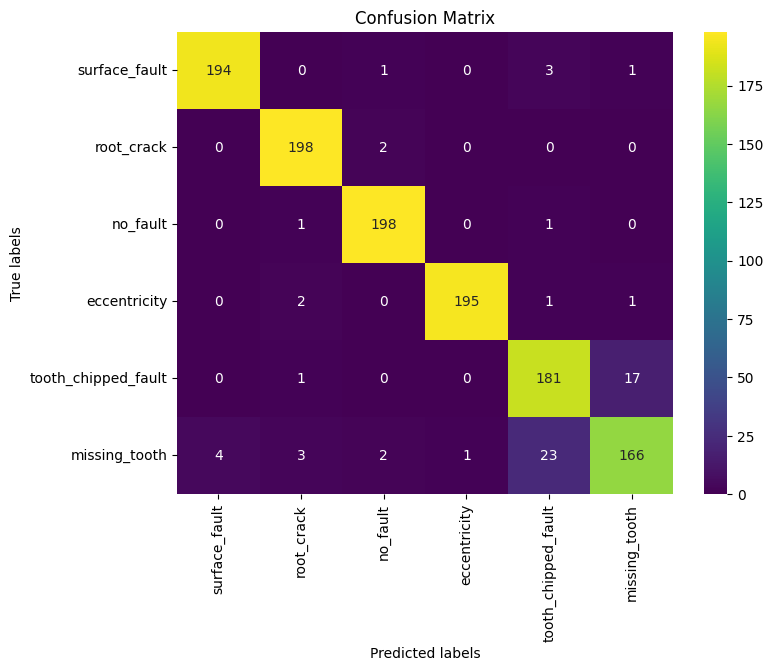

In [151]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Бинарная классификация

In [249]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [250]:
df = get_all_features_and_targets(n_cols=150, do_fft=False)
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,eccentricity,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,eccentricity,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,eccentricity,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,eccentricity,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,eccentricity,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,tooth_chipped_fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,tooth_chipped_fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,tooth_chipped_fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [251]:
df['defect'] = np.where(df['defect'] == 'no_fault', 'no_fault', 'fault')
df

,defect,0,1,2,3,4,5,6,7,8,...,142,143,144,145,146,147,148,149,velocity,load
0,fault,3.503794,3.504284,3.501296,3.502646,3.502895,3.504385,3.501738,3.501451,3.502886,...,3.502059,3.502401,3.502008,3.502532,3.502168,3.503452,3.502139,3.503672,8.332031,0.0
1,fault,3.502760,3.501581,3.502624,3.502988,3.502616,3.503119,3.502050,3.502033,3.501911,...,3.505095,3.502054,3.502726,3.504403,3.503815,3.503268,3.502291,3.504622,8.332031,0.0
2,fault,3.503811,3.504516,3.502063,3.503334,3.504596,3.505016,3.503701,3.502291,3.503794,...,3.503545,3.502848,3.503642,3.503317,3.501953,3.502046,3.503060,3.502029,8.332031,0.0
3,fault,3.504140,3.501932,3.502958,3.501358,3.500961,3.503009,3.502646,3.499939,3.502037,...,3.503828,3.502882,3.502886,3.503351,3.503136,3.501852,3.502624,3.503815,8.332031,0.0
4,fault,3.502794,3.503614,3.502059,3.502536,3.503579,3.504297,3.503097,3.501358,3.503313,...,3.502295,3.500526,3.504702,3.503330,3.503921,3.501852,3.503500,3.502620,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,fault,3.521564,3.467792,3.529033,3.476408,3.491611,3.510696,3.500587,3.520705,3.507101,...,3.526941,3.489998,3.473191,3.521295,3.508953,3.482174,3.528465,3.495734,40.000000,80.0
5972,fault,3.508022,3.502168,3.512502,3.490336,3.486260,3.501365,3.503475,3.486040,3.515675,...,3.502200,3.511373,3.479453,3.514994,3.487915,3.502930,3.515036,3.491246,40.000000,80.0
5973,fault,3.491869,3.521329,3.516670,3.479993,3.515390,3.498440,3.502553,3.490516,3.499569,...,3.486196,3.502972,3.485496,3.507658,3.504914,3.485691,3.488048,3.516261,40.000000,80.0
5974,fault,3.490405,3.501801,3.503596,3.499653,3.522508,3.493943,3.497095,3.497760,3.501318,...,3.502893,3.520132,3.499816,3.505469,3.492069,3.504319,3.481774,3.492658,40.000000,80.0


In [252]:
X = df.drop(columns='defect')
y = df['defect']

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [254]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

0.8336120401337793

In [256]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8336120401337793
Recall = 1.0
roc_auc = 0.473460582753285


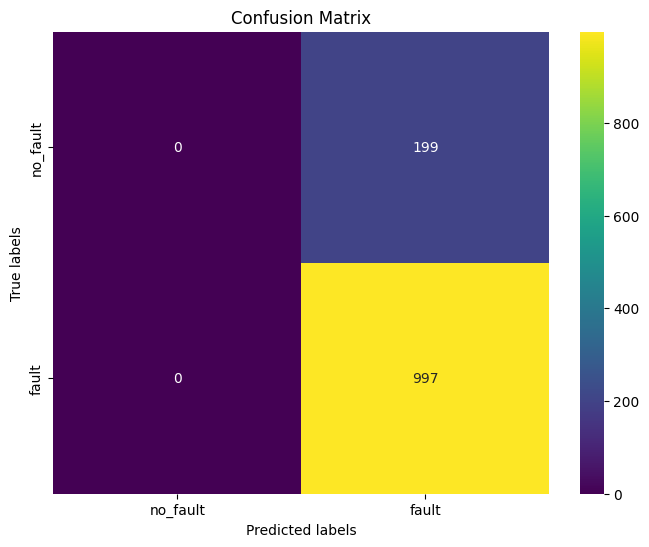

In [257]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Дерево решений

In [267]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-19 01:00:04,734] A new study created in memory with name: Tree
[I 2024-05-19 01:00:05,805] Trial 0 finished with value: 0.6599867427380981 and parameters: {'max_depth': 12}. Best is trial 0 with value: 0.6599867427380981.
[I 2024-05-19 01:00:06,892] Trial 1 finished with value: 0.639753635882989 and parameters: {'max_depth': 74}. Best is trial 0 with value: 0.6599867427380981.
[I 2024-05-19 01:00:08,006] Trial 2 finished with value: 0.634726924078502 and parameters: {'max_depth': 39}. Best is trial 0 with value: 0.6599867427380981.
[I 2024-05-19 01:00:09,125] Trial 3 finished with value: 0.6372442255944067 and parameters: {'max_depth': 15}. Best is trial 0 with value: 0.6599867427380981.
[I 2024-05-19 01:00:10,267] Trial 4 finished with value: 0.6466624054039124 and parameters: {'max_depth': 70}. Best is trial 0 with value: 0.6599867427380981.
[I 2024-05-19 01:00:11,415] Trial 5 finished with value: 0.6322175137899197 and parameters: {'max_depth': 48}. Best is trial 0 with v

In [268]:
study.best_params

{'max_depth': 9}

In [269]:
best_params = {'max_depth': 9}

In [270]:
d_tree = DecisionTreeClassifier(**best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.7759197324414716

In [271]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8670694864048338
Recall = 0.8635907723169508
roc_auc = 0.6007242834029727


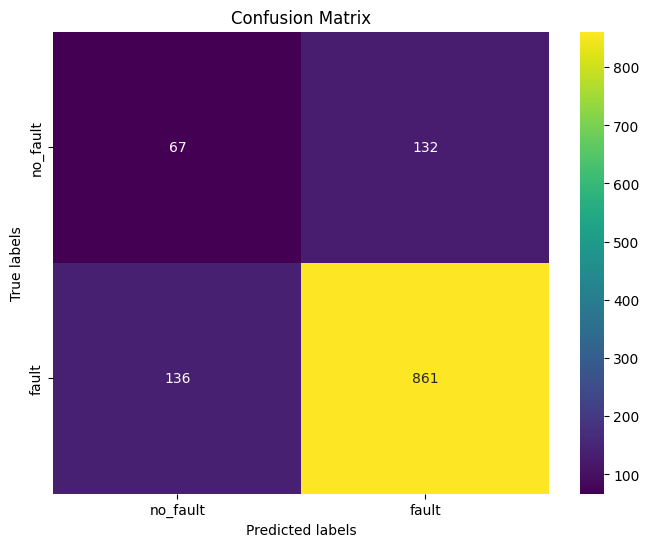

In [272]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Градиентный бустинг

In [277]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [278]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, timeout=100)

[I 2024-05-19 01:02:46,583] A new study created in memory with name: Boosting
[I 2024-05-19 01:02:47,344] Trial 0 finished with value: 0.9295707961459245 and parameters: {'learning_rate': 0.4069708080191969, 'num_leaves': 1723, 'reg_lambda': 0.6110518724003159, 'reg_alpha': 0.038791509091996246, 'min_child_samples': 14}. Best is trial 0 with value: 0.9295707961459245.
[I 2024-05-19 01:02:47,673] Trial 1 finished with value: 0.8964513150730332 and parameters: {'learning_rate': 0.4761057267337038, 'num_leaves': 1134, 'reg_lambda': 0.08974134694046032, 'reg_alpha': 0.9276479251933755, 'min_child_samples': 39}. Best is trial 0 with value: 0.9295707961459245.
[I 2024-05-19 01:02:47,959] Trial 2 finished with value: 0.7563859757108022 and parameters: {'learning_rate': 1.8764069381509436, 'num_leaves': 757, 'reg_lambda': 0.7400672308465043, 'reg_alpha': 0.943155815658243, 'min_child_samples': 98}. Best is trial 0 with value: 0.9295707961459245.
[I 2024-05-19 01:02:48,579] Trial 3 finished wit

[I 2024-05-19 01:03:05,882] Trial 28 finished with value: 0.9202118005413381 and parameters: {'learning_rate': 0.3511835004866529, 'num_leaves': 679, 'reg_lambda': 0.42473234323453823, 'reg_alpha': 0.9971257614670932, 'min_child_samples': 76}. Best is trial 24 with value: 0.9406816442161249.
[I 2024-05-19 01:03:06,393] Trial 29 finished with value: 0.8958121256599039 and parameters: {'learning_rate': 0.7955542837893781, 'num_leaves': 1746, 'reg_lambda': 0.5542083077687009, 'reg_alpha': 0.822690552859209, 'min_child_samples': 32}. Best is trial 24 with value: 0.9406816442161249.
[I 2024-05-19 01:03:07,070] Trial 30 finished with value: 0.9170789832942717 and parameters: {'learning_rate': 0.47825661780110346, 'num_leaves': 2258, 'reg_lambda': 0.28591465468602184, 'reg_alpha': 0.5761027843968541, 'min_child_samples': 46}. Best is trial 24 with value: 0.9406816442161249.
[I 2024-05-19 01:03:07,844] Trial 31 finished with value: 0.9431437071407716 and parameters: {'learning_rate': 0.1513901

[I 2024-05-19 01:03:27,833] Trial 56 finished with value: 0.9411077704915446 and parameters: {'learning_rate': 0.17498383317642363, 'num_leaves': 1097, 'reg_lambda': 0.30971704961871444, 'reg_alpha': 0.7609411646873632, 'min_child_samples': 63}. Best is trial 32 with value: 0.9441695666927078.
[I 2024-05-19 01:03:28,498] Trial 57 finished with value: 0.9281582664551818 and parameters: {'learning_rate': 0.3133817873629759, 'num_leaves': 1530, 'reg_lambda': 0.29247618252463276, 'reg_alpha': 0.7445763802626325, 'min_child_samples': 62}. Best is trial 32 with value: 0.9441695666927078.
[I 2024-05-19 01:03:29,311] Trial 58 finished with value: 0.9323879643000876 and parameters: {'learning_rate': 0.16062152266395635, 'num_leaves': 1060, 'reg_lambda': 0.3613719427235346, 'reg_alpha': 0.590449191039986, 'min_child_samples': 48}. Best is trial 32 with value: 0.9441695666927078.
[I 2024-05-19 01:03:30,566] Trial 59 finished with value: 0.9393717004805757 and parameters: {'learning_rate': 0.05864

[I 2024-05-19 01:04:09,625] Trial 84 finished with value: 0.9426071036828358 and parameters: {'learning_rate': 0.10404387442094658, 'num_leaves': 3900, 'reg_lambda': 0.16567467387784435, 'reg_alpha': 0.6440372560426999, 'min_child_samples': 30}. Best is trial 71 with value: 0.9476180330326777.
[I 2024-05-19 01:04:11,114] Trial 85 finished with value: 0.8817262848890888 and parameters: {'learning_rate': 0.009086478992943313, 'num_leaves': 3353, 'reg_lambda': 0.1859510422128897, 'reg_alpha': 0.5926649137672086, 'min_child_samples': 45}. Best is trial 71 with value: 0.9476180330326777.
[I 2024-05-19 01:04:12,465] Trial 86 finished with value: 0.9209614671369839 and parameters: {'learning_rate': 0.2628507248723988, 'num_leaves': 3995, 'reg_lambda': 0.09904029665635022, 'reg_alpha': 0.6206682316812782, 'min_child_samples': 36}. Best is trial 71 with value: 0.9476180330326777.
[I 2024-05-19 01:04:14,459] Trial 87 finished with value: 0.9469314962556126 and parameters: {'learning_rate': 0.156

In [279]:
study.best_params

{'learning_rate': 0.13452776305912797,
 'num_leaves': 3854,
 'reg_lambda': 0.2339479456208388,
 'reg_alpha': 0.5632984206878877,
 'min_child_samples': 41}

In [280]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.8837792642140468

In [281]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8776408450704225
Recall = 1.0
roc_auc = 0.9485290040977203


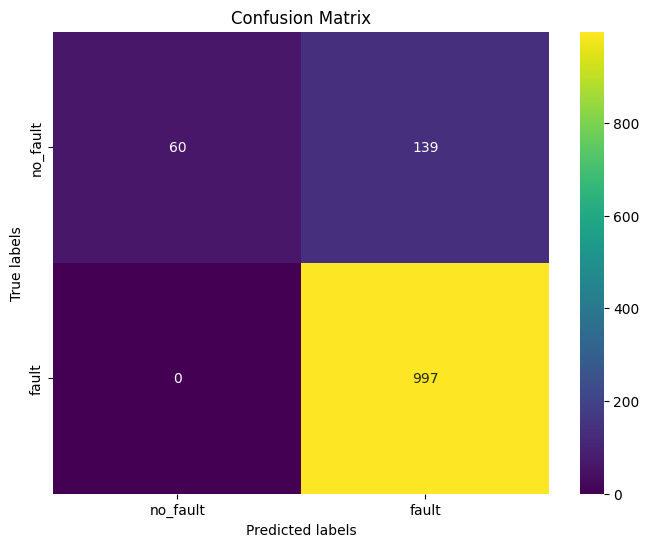

In [282]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

**Фурье**

In [283]:
df = get_all_features_and_targets(n_cols=150, do_fft=True)
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,eccentricity,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,eccentricity,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,eccentricity,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,eccentricity,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,eccentricity,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,tooth_chipped_fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,tooth_chipped_fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,tooth_chipped_fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,tooth_chipped_fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [284]:
df['defect'] = np.where(df['defect'] == 'no_fault', 'no_fault', 'fault')
df

,defect,0,1,2,3,4,5,6,7,8,...,68,69,70,71,72,73,74,75,velocity,load
0,fault,525.409424,0.021895,0.012843,0.025841,0.008291,0.009013,0.006470,0.009347,0.002884,...,0.002850,0.008398,0.018357,0.004684,0.011497,0.017193,0.003088,0.001824,8.332031,0.0
1,fault,525.427240,0.019269,0.015264,0.006059,0.009207,0.014268,0.013022,0.008167,0.010033,...,0.007666,0.012062,0.006743,0.004319,0.010720,0.008597,0.008305,0.001188,8.332031,0.0
2,fault,525.433246,0.024946,0.007743,0.021699,0.004679,0.007978,0.007247,0.004359,0.005465,...,0.009915,0.005249,0.008721,0.006191,0.007681,0.006279,0.009670,0.009833,8.332031,0.0
3,fault,525.439797,0.008101,0.005131,0.015462,0.004521,0.018895,0.006041,0.011705,0.007960,...,0.012197,0.002144,0.016790,0.008058,0.005529,0.012005,0.016198,0.005565,8.332031,0.0
4,fault,525.415364,0.013370,0.007470,0.025987,0.008280,0.007523,0.006334,0.014291,0.002011,...,0.002236,0.010304,0.013810,0.005147,0.007098,0.004616,0.008535,0.014549,8.332031,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,fault,525.211956,0.095813,0.047448,0.030635,0.089691,0.054262,0.079203,0.050098,0.074249,...,0.384296,0.396006,0.169942,0.288350,0.296430,0.044249,0.060414,0.074838,40.000000,80.0
5972,fault,525.094227,0.023755,0.096376,0.058601,0.002962,0.099958,0.035200,0.076253,0.059269,...,0.026721,0.139978,0.149836,0.401128,0.093942,0.161306,0.043332,0.031946,40.000000,80.0
5973,fault,525.265549,0.017539,0.091243,0.079595,0.125605,0.014317,0.014682,0.045009,0.038478,...,0.185478,0.254081,0.095829,0.360771,0.270639,0.122595,0.293244,0.113090,40.000000,80.0
5974,fault,525.042368,0.011552,0.086697,0.041887,0.075564,0.005257,0.078779,0.100489,0.073642,...,0.077747,0.101659,0.122803,0.252712,0.220346,0.211800,0.175265,0.090863,40.000000,80.0


In [285]:
X = df.drop(columns='defect')
y = df['defect']

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=18)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=18)

Логистическая регрессия

In [287]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
predictions = log_reg.predict(X_test)
accuracy_score(y_test, predictions)

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8461538461538461

In [288]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.8447837150127226
Recall = 0.9989969909729187
roc_auc = 0.8107488294027813


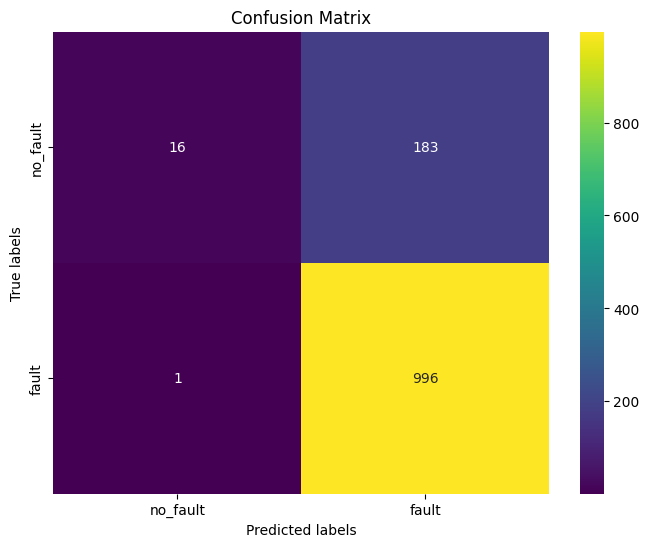

In [289]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Дерево решений

In [290]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'criterion': 'entropy',
    }
 
    d_tree = DecisionTreeClassifier(**params)
    d_tree.fit(X_train, y_train)
    
    preds = d_tree.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc

study = optuna.create_study(study_name='Tree', direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-19 01:08:55,300] A new study created in memory with name: Tree
[I 2024-05-19 01:08:55,702] Trial 0 finished with value: 0.9358758867766703 and parameters: {'max_depth': 100}. Best is trial 0 with value: 0.9358758867766703.
[I 2024-05-19 01:08:56,108] Trial 1 finished with value: 0.9346132904050567 and parameters: {'max_depth': 18}. Best is trial 0 with value: 0.9358758867766703.
[I 2024-05-19 01:08:56,346] Trial 2 finished with value: 0.9646196822991879 and parameters: {'max_depth': 3}. Best is trial 2 with value: 0.9646196822991879.
[I 2024-05-19 01:08:56,754] Trial 3 finished with value: 0.9371305919209615 and parameters: {'max_depth': 61}. Best is trial 2 with value: 0.9646196822991879.
[I 2024-05-19 01:08:57,159] Trial 4 finished with value: 0.9314686363170064 and parameters: {'max_depth': 75}. Best is trial 2 with value: 0.9646196822991879.
[I 2024-05-19 01:08:57,566] Trial 5 finished with value: 0.9415299511533028 and parameters: {'max_depth': 56}. Best is trial 2 with

In [291]:
study.best_params

{'max_depth': 6}

In [292]:
best_params = {'max_depth': 6}

In [293]:
d_tree = DecisionTreeClassifier(**best_params)
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
accuracy_score(y_test, predictions)

0.9690635451505016

In [294]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, d_tree.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9724409448818898
Recall = 0.9909729187562688
roc_auc = 0.965229860435578


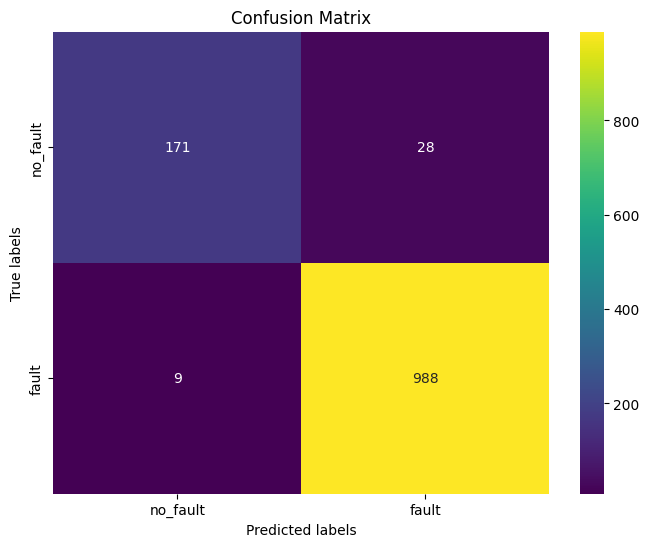

In [296]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Градиентный бустинг

In [297]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 2),
        'num_leaves': trial.suggest_int('num_leaves', 35, 4095),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'objective': 'binary',
        'random_state': 42,
        'verbose': -1
    }
 
    clf = LGBMClassifier(**params)
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, preds)
    
    return roc_auc
    

In [298]:
study = optuna.create_study(direction='maximize', study_name='Boosting')
study.optimize(objective, n_trials=100)

[I 2024-05-19 01:09:52,364] A new study created in memory with name: Boosting
[I 2024-05-19 01:09:52,469] Trial 0 finished with value: 0.9992424421770317 and parameters: {'learning_rate': 0.9823810707522552, 'num_leaves': 975, 'reg_lambda': 0.539433392587952, 'reg_alpha': 0.2697789479468615, 'min_child_samples': 65}. Best is trial 0 with value: 0.9992424421770317.
[I 2024-05-19 01:09:52,664] Trial 1 finished with value: 0.9972065055278048 and parameters: {'learning_rate': 1.1917367014787028, 'num_leaves': 2871, 'reg_lambda': 0.6927442045639675, 'reg_alpha': 0.9987364115067751, 'min_child_samples': 91}. Best is trial 0 with value: 0.9992424421770317.
[I 2024-05-19 01:09:52,923] Trial 2 finished with value: 0.9956361512906102 and parameters: {'learning_rate': 1.4544362486503477, 'num_leaves': 3620, 'reg_lambda': 0.2490411781589369, 'reg_alpha': 0.8377178198034805, 'min_child_samples': 58}. Best is trial 0 with value: 0.9992424421770317.
[I 2024-05-19 01:09:52,972] Trial 3 finished with v

[I 2024-05-19 01:09:58,620] Trial 28 finished with value: 0.9996133298611933 and parameters: {'learning_rate': 0.27827397541984034, 'num_leaves': 3966, 'reg_lambda': 0.16212171114712162, 'reg_alpha': 0.007524218519026765, 'min_child_samples': 90}. Best is trial 28 with value: 0.9996133298611933.
[I 2024-05-19 01:09:59,062] Trial 29 finished with value: 0.9991398562218382 and parameters: {'learning_rate': 0.5442072899550469, 'num_leaves': 3963, 'reg_lambda': 0.13728367537241232, 'reg_alpha': 0.18812037349067912, 'min_child_samples': 82}. Best is trial 28 with value: 0.9996133298611933.
[I 2024-05-19 01:09:59,672] Trial 30 finished with value: 0.9995028526786771 and parameters: {'learning_rate': 0.27851783123880797, 'num_leaves': 4010, 'reg_lambda': 0.24075139691738978, 'reg_alpha': 0.0021209437629224268, 'min_child_samples': 58}. Best is trial 28 with value: 0.9996133298611933.
[I 2024-05-19 01:10:00,137] Trial 31 finished with value: 0.9991950948130962 and parameters: {'learning_rate':

[I 2024-05-19 01:10:15,303] Trial 56 finished with value: 0.9988715544928702 and parameters: {'learning_rate': 0.3300766653631245, 'num_leaves': 3626, 'reg_lambda': 0.0486085641885036, 'reg_alpha': 0.12391282332396214, 'min_child_samples': 100}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:15,847] Trial 57 finished with value: 0.999218768495064 and parameters: {'learning_rate': 0.41252678157608297, 'num_leaves': 3758, 'reg_lambda': 0.1084879979919673, 'reg_alpha': 0.044902482631430526, 'min_child_samples': 63}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:16,439] Trial 58 finished with value: 0.9990135965846768 and parameters: {'learning_rate': 0.20034168728563145, 'num_leaves': 3524, 'reg_lambda': 0.16080039301169782, 'reg_alpha': 0.09113733629254814, 'min_child_samples': 72}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:16,872] Trial 59 finished with value: 0.9990057053573542 and parameters: {'learning_rate': 0.4

[I 2024-05-19 01:10:30,896] Trial 84 finished with value: 0.9996843509070966 and parameters: {'learning_rate': 0.10877646048688314, 'num_leaves': 3427, 'reg_lambda': 0.000358992349478629, 'reg_alpha': 0.05344269895701641, 'min_child_samples': 64}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:31,663] Trial 85 finished with value: 0.9996527859978062 and parameters: {'learning_rate': 0.05192632116938767, 'num_leaves': 3524, 'reg_lambda': 0.002277866735560607, 'reg_alpha': 0.2061570862650925, 'min_child_samples': 59}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:32,287] Trial 86 finished with value: 0.999258224631677 and parameters: {'learning_rate': 0.03846678280490537, 'num_leaves': 3570, 'reg_lambda': 0.0016131980579411065, 'reg_alpha': 0.21312711325388436, 'min_child_samples': 60}. Best is trial 44 with value: 0.9997711544076451.
[I 2024-05-19 01:10:32,842] Trial 87 finished with value: 0.9994318316327738 and parameters: {'learning_rate':

In [299]:
study.best_params

{'learning_rate': 0.11453688551815926,
 'num_leaves': 3346,
 'reg_lambda': 0.045784823337154834,
 'reg_alpha': 0.05527194594508485,
 'min_child_samples': 67}

In [300]:
boosting_clf = LGBMClassifier(verbose=-1, **study.best_params)
boosting_clf.fit(X_train, y_train)
predictions = boosting_clf.predict(X_test)
accuracy_score(y_test, predictions)

0.9874581939799331

In [301]:
precision = precision_score(y_test, predictions, pos_label='fault')
recall = recall_score(y_test, predictions, pos_label='fault')
roc_auc = roc_auc_score(y_test, boosting_clf.predict_proba(X_test)[:, 1])
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"roc_auc = {roc_auc}")

Precision = 0.9861386138613861
Recall = 0.9989969909729187
roc_auc = 0.9980645453949789


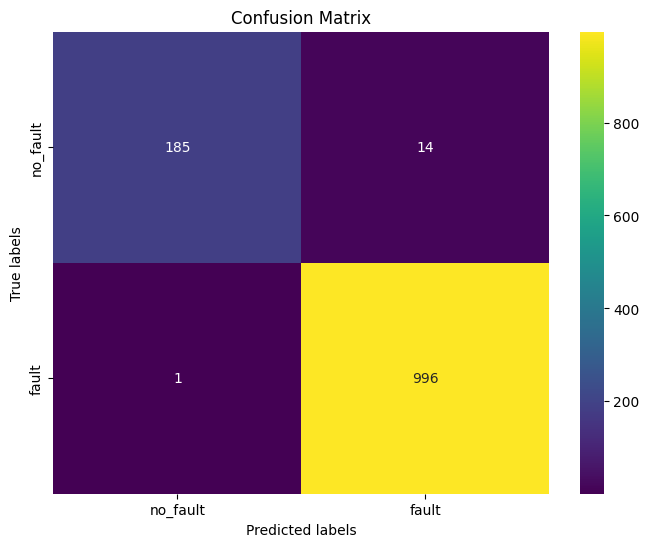

In [303]:
labels = y_test.unique()
cm = confusion_matrix(y_test, predictions, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='viridis', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()